In [2]:
"""
Load, clean and merge datasets
"""
from __future__ import annotations
import pandas as pd
import preprocessing as pp
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
import re
%time
%matplotlib inline

print("Loading datasets ... ", end='')
# Load dataset (As a tuple of three DFs)
dfs: tuple[pd.DataFrame] = pp.load_dataset()
# Clean datasets
pp.clean_datasets(dfs)
# Create merged dataset
df_merged = pp.merge_datasets(dfs).set_index('id_audit')
print("Done!")

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.25 µs
Loading datasets ... Done!


In [3]:
""" Filter merged dataset and preprocess before applying Isolation Forest to the data """
# Filter columns to keep only those with at least n non-NaN values
df_merged = df_merged.dropna(axis=1, thresh=5)

# Drop any columns not to be used in Isolation forest
df_data = df_merged.drop(columns=['serial', 'customer'])

# Show dataset
print(df_data)
print(df_data.columns)

# Handle missing values by filling with the median (IF doesn't work well with NaN values)
df_data.fillna(df_data.median(), inplace=True)

           D10  D12  D13  D14  D15  D16  D17   D18   D19    D4  ...  Gwatts  \
id_audit                                                        ...           
21        30.5  NaN  NaN  NaN  NaN  NaN  NaN  33.6  34.6  25.0  ...    40.0   
23        52.3  NaN  NaN  NaN  NaN  NaN  NaN  55.0  55.5  45.0  ...    60.0   
25        56.0  NaN  NaN  NaN  NaN  NaN  NaN  65.7  59.4  52.8  ...    60.0   
147       23.0  NaN  NaN  NaN  NaN  NaN  NaN  31.2  27.3  23.5  ...    20.0   
746       36.0  NaN  NaN  NaN  NaN  NaN  NaN  46.3  39.9  37.0  ...    60.0   
...        ...  ...  ...  ...  ...  ...  ...   ...   ...   ...  ...     ...   
1970967   51.3  NaN  NaN  NaN  NaN  NaN  NaN  64.7  57.4  50.5  ...    60.0   
1972213   12.0  NaN  NaN  NaN  NaN  NaN  NaN  21.0  15.2  11.0  ...    60.0   
1972723   14.5  NaN  NaN  NaN  NaN  NaN  NaN  25.8  19.0  15.3  ...    20.0   
1972793   38.0  NaN  NaN  NaN  NaN  NaN  NaN  38.5  41.9  27.5  ...    60.0   
1972937   34.0  NaN  NaN  NaN  NaN  NaN  NaN  39.5  

In [4]:
""" Split, scale and train """

# Select features to train on
features = list(filter(lambda v: re.match('^\w\d+$', v), df_data.columns))

# Standard scale the data
scaler = StandardScaler()
df_data_scaled = df_data[features]#pd.DataFrame(scaler.fit_transform(df_data[features]), columns=features)

# Apply IsolationForest
iso_forest = IsolationForest(
    #contamination=0.4,
    bootstrap=True,
    verbose=1
)
anomaly_labels = iso_forest.fit_predict(df_data_scaled)

# Convert to -1 for anomaly, 1 for normal
df_anomalies = pd.DataFrame(anomaly_labels, columns=['anomaly'], index=df_data.index)
df_data['anomaly'] = df_anomalies

print('Done')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


Done


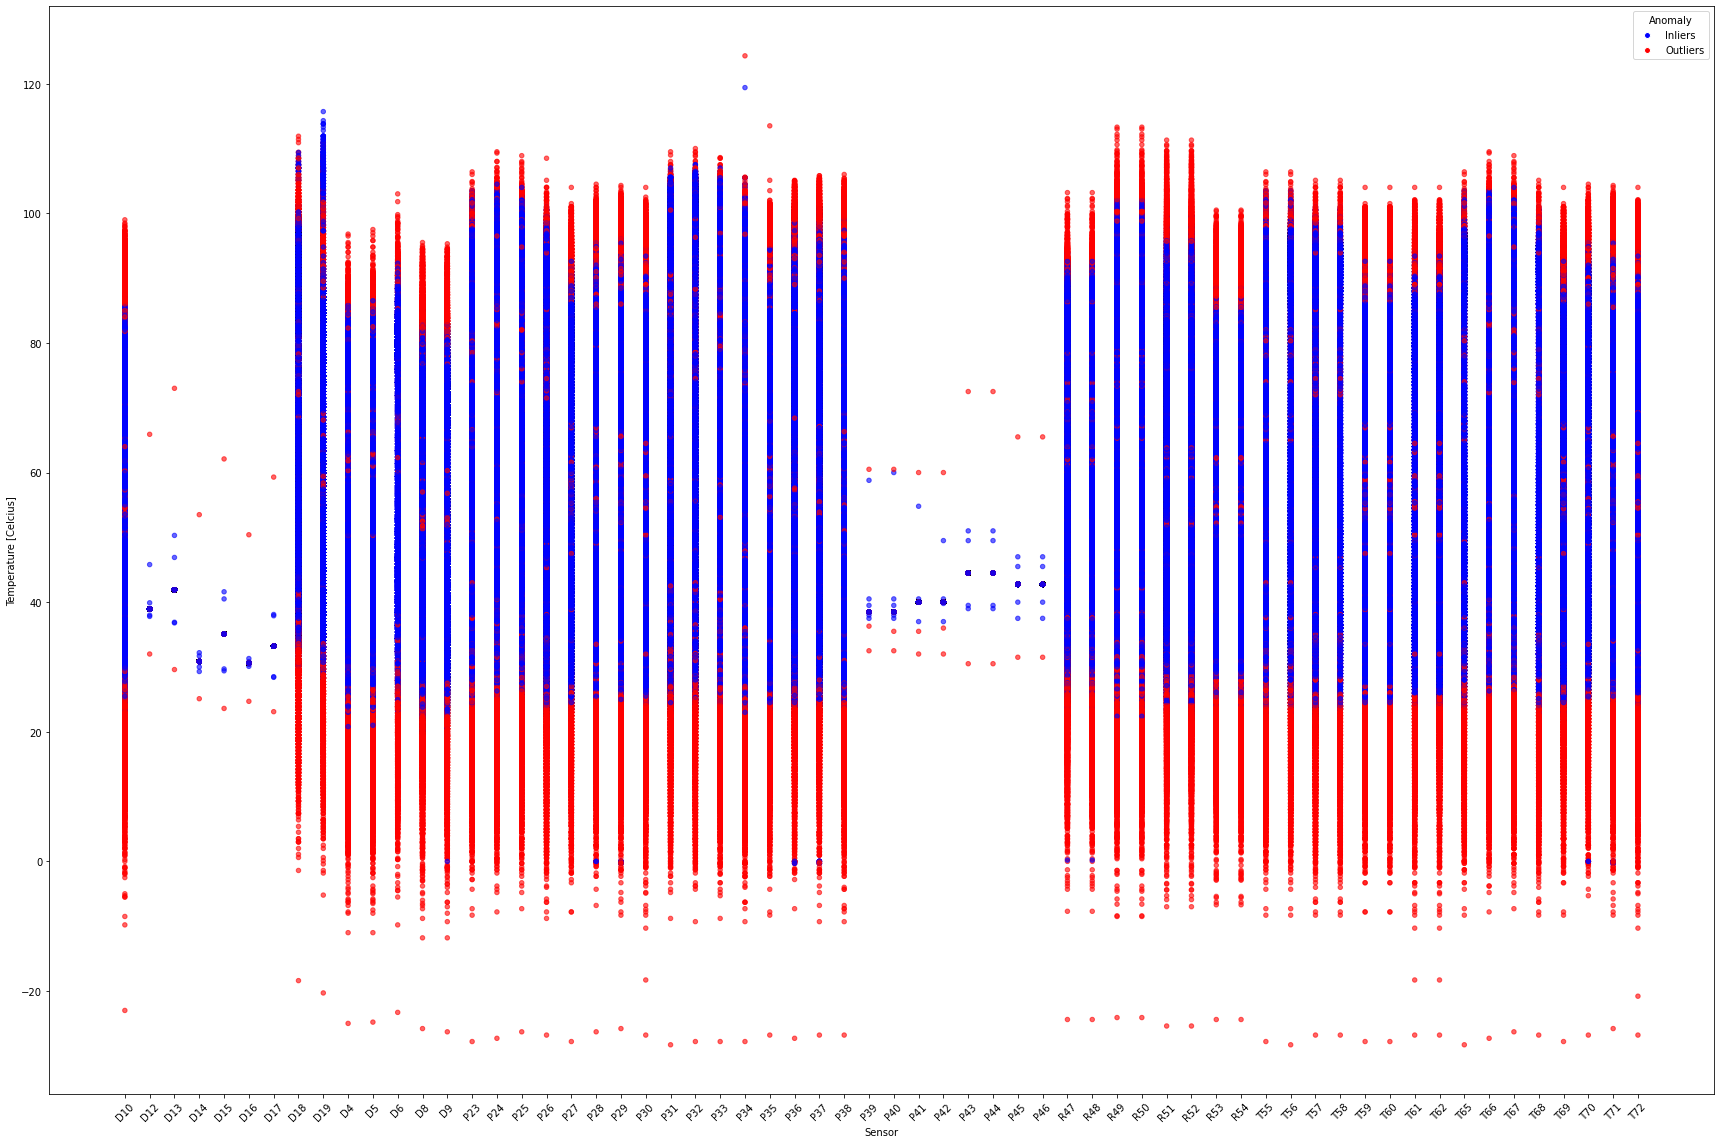

In [5]:
""" Plot results """
# Create x positions for each sensor
n_rows = (len(df_data), 1)  # Shape to be passed to np.full
x_positions = np.arange(len(features))

# Plot data
colors = df_data['anomaly'].map(
    {1: 'blue', -1: 'red'}
)
plt.figure(figsize=(24, 16))
for i, column in enumerate(features):
    x = np.full(n_rows, x_positions[i])  # All points for each sensor are at the same x position
    plt.scatter(x, df_data[column], c=colors, s=20, alpha=0.6)

# Customize plot
plt.xticks(x_positions, features, rotation=45)  # Set x-axis ticks to column names
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Inliers', markerfacecolor='blue'),
                    plt.Line2D([0], [0], marker='o', color='w', label='Outliers', markerfacecolor='red')],
           title="Anomaly", loc="upper right")
plt.title("")
plt.xlabel("Sensor")
plt.ylabel("Temperature [Celcius]")
plt.tight_layout()
plt.show()


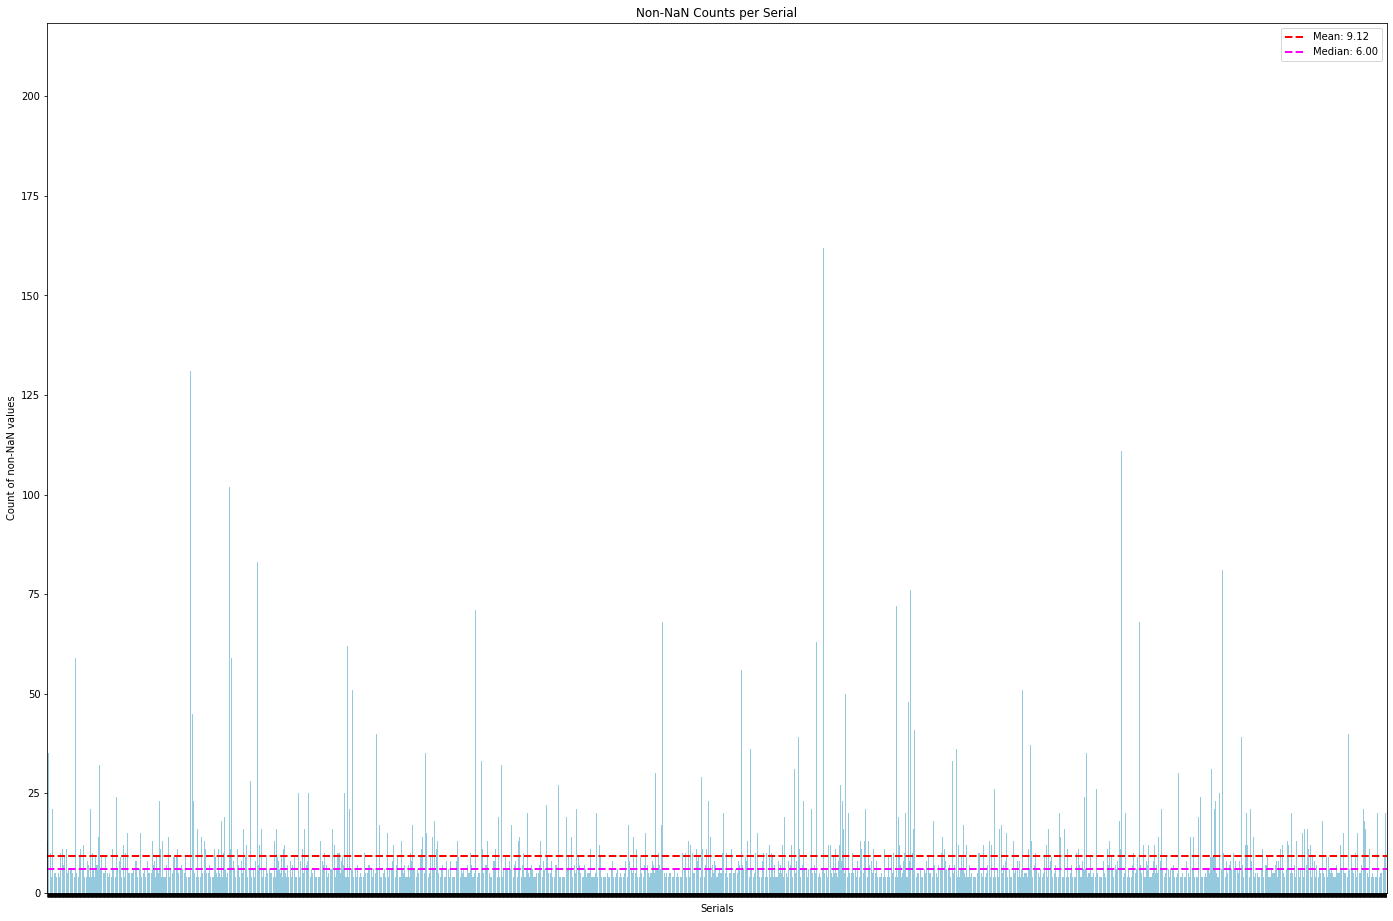

In [6]:
""" One serial per column (one alarm per row) """
# Crate pivot table
for d in dfs:
    d.set_index('id_audit')
df_serial = dfs[0].combine_first(dfs[1]).combine_first(dfs[2])
df_serial = pp.tranpose_dataframe(df_serial, key_column='serial',
                                            value_columns=['temp_value']).set_index('id_audit')

# Convert serials to integers (became floats after merge)
df_serial.columns = df_serial.columns.astype(int)

# Filter table to keep only serials with at least 4 alarms
df_serial = df_serial.dropna(axis=1, thresh=4)

# Encode all columns
label_encoder = LabelEncoder()
df_serial = df_serial.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)

# Calculate not-NaN values per serial
serial_counts = df_serial.notna().sum()
serial_mean_count: int = serial_counts.mean()
serial_median_count:int = serial_counts.median()
    
# Plot
plt.figure(figsize=(24, 16))

plot_data = serial_counts.reset_index()
plot_data.columns = ['Serial', 'Non-NaN Count']
plot_data = plot_data.sort_values('Non-NaN Count', ascending=False)

sns.barplot(x='Serial', y='Non-NaN Count', data=plot_data, color='skyblue')

plt.axhline(serial_mean_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {serial_mean_count:.2f}')
plt.axhline(serial_median_count, color='magenta', linestyle='dashed', linewidth=2, label=f'Median: {serial_median_count:.2f}')
plt.xlabel('Serials')
plt.ylabel('Count of non-NaN values')
plt.title('Non-NaN Counts per Serial')
plt.xticks(ticks=plt.gca().get_xticks(), labels=[])
plt.legend()

plt.show()

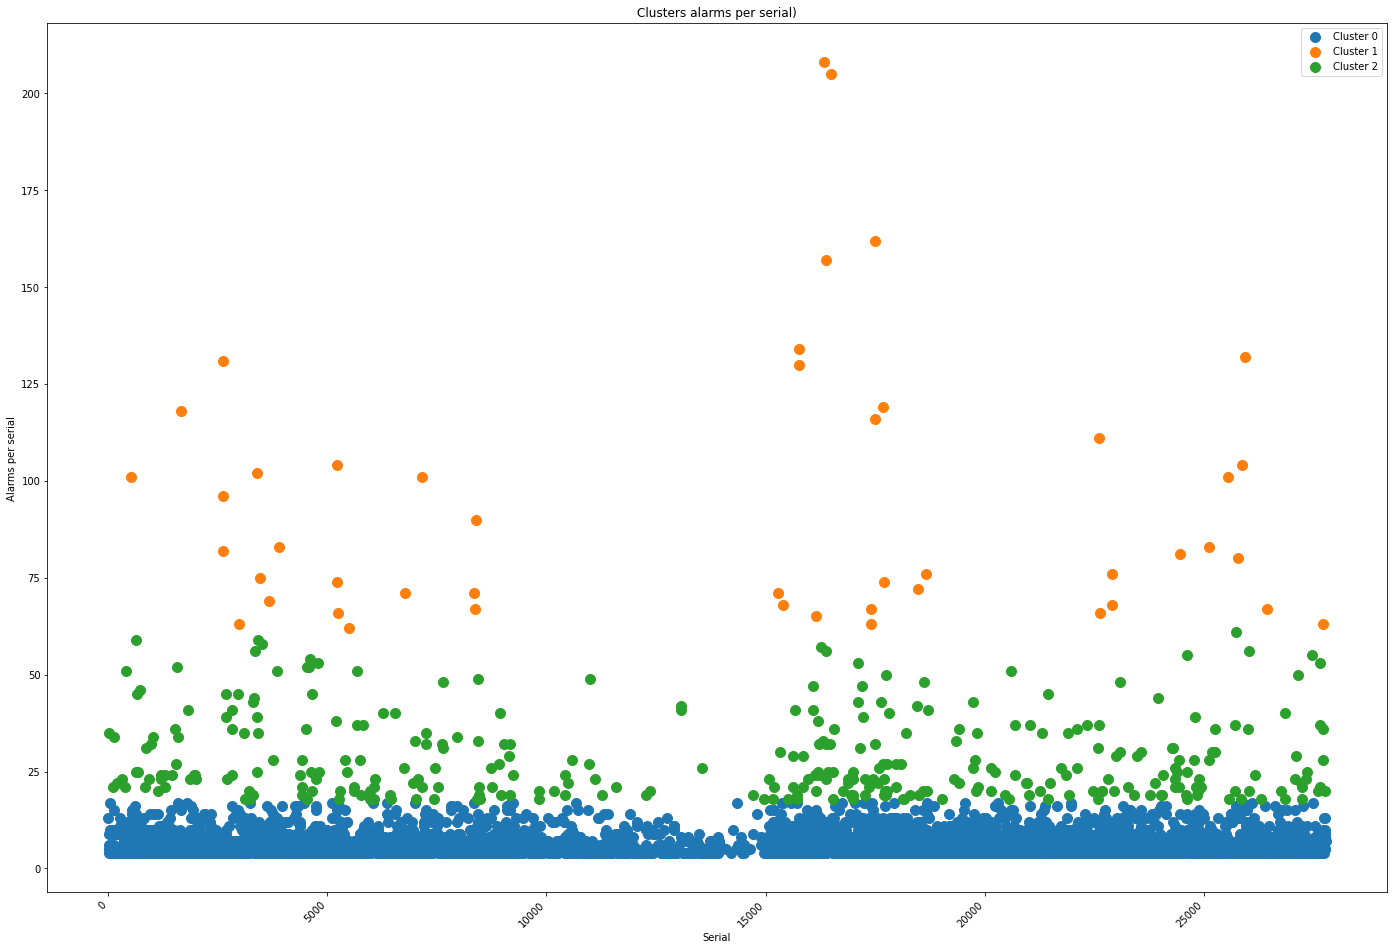

In [37]:
from sklearn.cluster import KMeans

# Perform cluster analisis
kmeans = KMeans(n_clusters=3, random_state=111, max_iter=1000, n_init=100)
alarms_per_serial_clusters = kmeans.fit_predict(serial_counts.values.reshape(-1, 1))

# Add labels
alarms_per_serial_data = pd.DataFrame({
    'Serial': df_serial.columns,
    'Count': serial_counts,
    'Cluster': alarms_per_serial_clusters
})

# Plot
plt.figure(figsize=(24,16))
for cluster, data in alarms_per_serial_data.groupby('Cluster'):
    plt.scatter(data['Serial'], data['Count'], label=f'Cluster {cluster}', s=100)

plt.xlabel('Serial')
plt.ylabel('Alarms per serial')
plt.title('Clusters alarms per serial)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/tmp/ipykernel_396/4135148598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_serials_df['anomaly'] = df_anomalies_serials


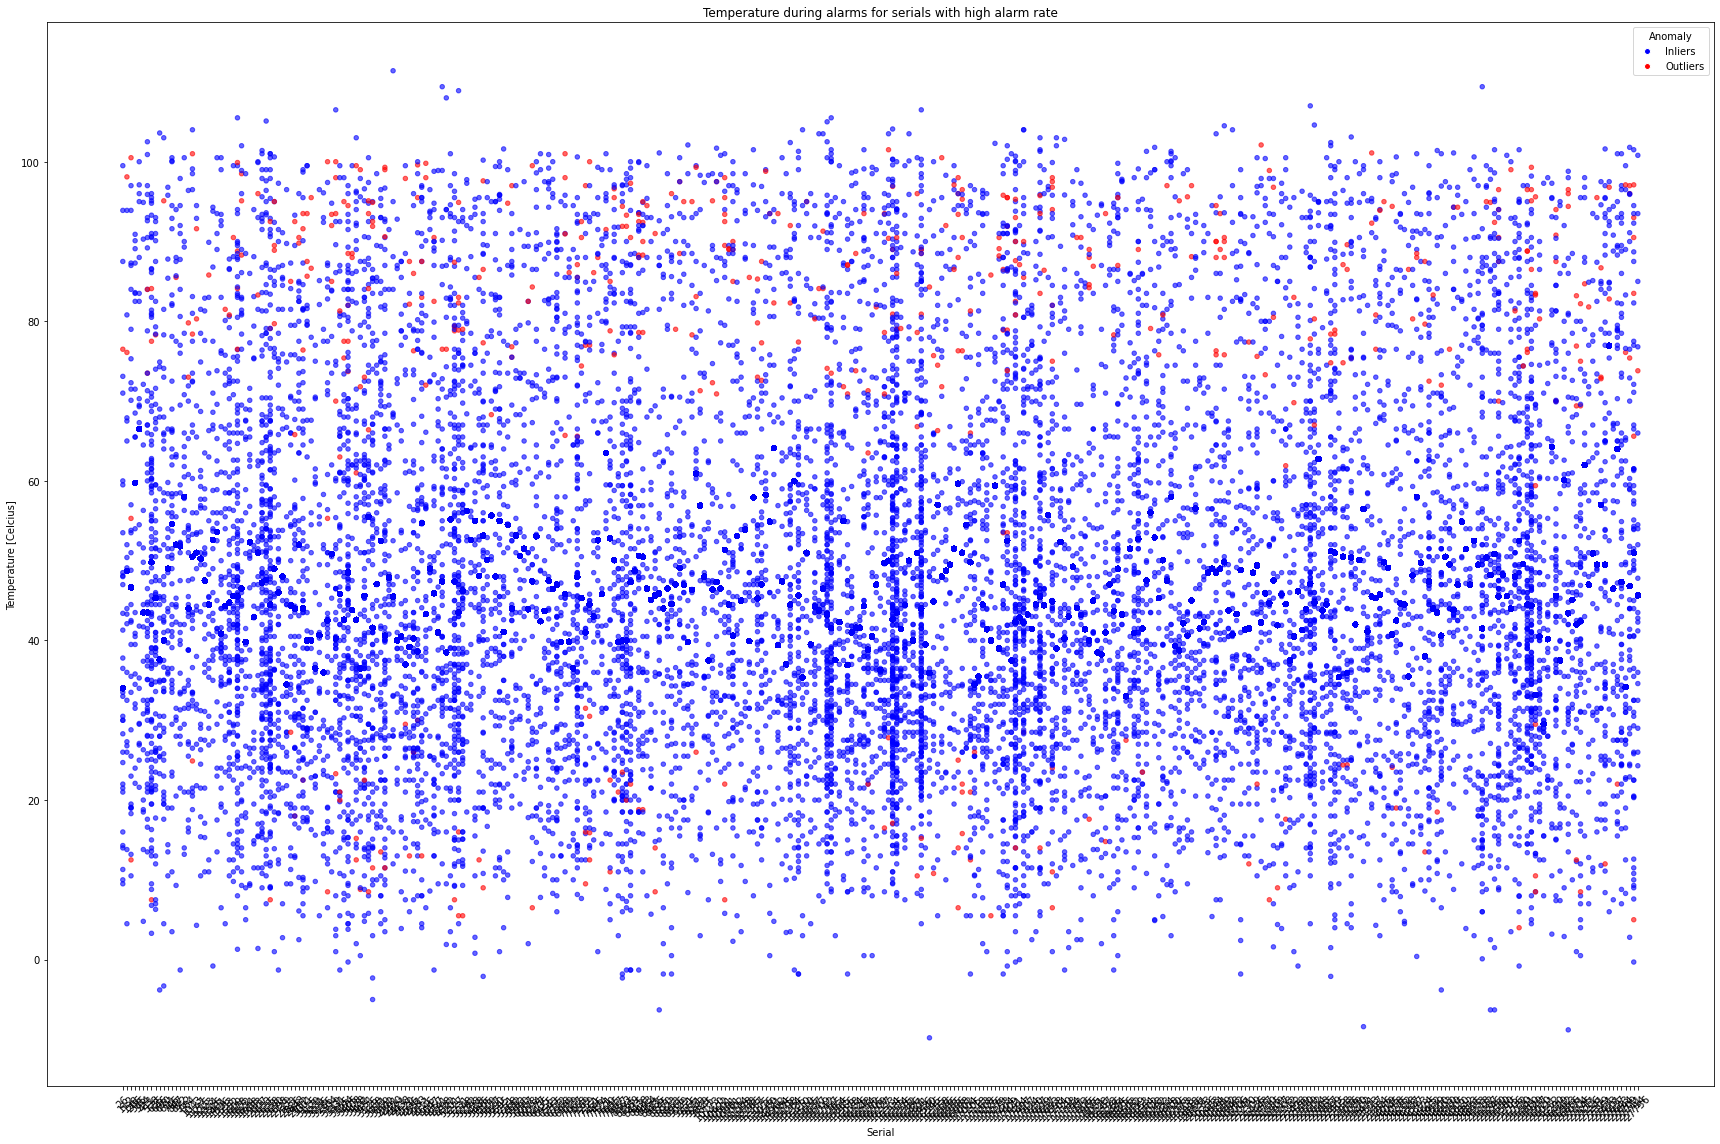

In [40]:
""" Explore serials contained within the clusters with highest number of alarms """

max_serials = alarms_per_serial_data[alarms_per_serial_data['Cluster'].isin([1, 2])]['Serial'].tolist()
max_serials_df = df_serial[max_serials]

# Handle missing values by filling with the median (IF doesn't work well with NaN values)
max_serials_df.fillna(max_serials_df.median(), inplace=True)

# Apply IsolationForest
iso_forest = IsolationForest(
    contamination=0.015,  # NOTE: If we leave out this parameter, the algorithm does not mark any datapoint as anomalous
    bootstrap=True,
    random_state=111
)
anomaly_labels_serials = iso_forest.fit_predict(max_serials_df)

# Convert to -1 for anomaly, 1 for normal
max_serials = max_serials_df.columns
df_anomalies_serials = pd.DataFrame(anomaly_labels_serials, columns=['anomaly'], index=max_serials_df.index)
max_serials_df['anomaly'] = df_anomalies_serials

""" Plot results """
# Create x positions for each sensor
n_rows = (len(max_serials_df), 1)  # Shape to be passed to np.full
x_positions = np.arange(len(max_serials))

# Map anomaly labels to colors: 1 = Inlier, -1 = Outlier
colors = max_serials_df['anomaly'].map(
    {1: 'blue', -1: 'red'}
)

# Plot data
plt.figure(figsize=(24, 16))

for i, column in enumerate(max_serials):
    x = np.full(n_rows, x_positions[i])  # All points for each sensor are at the same x position
    plt.scatter(x, max_serials_df[column], c=colors, s=20, alpha=0.6)
    
plt.xticks(x_positions, max_serials, rotation=45)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Inliers', markerfacecolor='blue'),
                    plt.Line2D([0], [0], marker='o', color='w', label='Outliers', markerfacecolor='red')],
           title="Anomaly", loc="upper right")
plt.title("Temperature during alarms for serials with high alarm rate")
plt.xlabel("Serial")
plt.ylabel("Temperature [Celcius]")
plt.tight_layout()
plt.show()

In [47]:
""" Plot anomalous vs non-anomalous alarms """
# Extract the sensor data from original dataset using results from isolation above
anomalous_audits = max_serials_df[max_serials_df['anomaly'] == -1]
non_anomalous_audits = max_serials_df[max_serials_df['anomaly'] == 1]
try:
    df_merged = df_merged.reset_index()
except ValueError:
    pass
df_anomalous = df_merged[df_merged['id_audit'].isin(anomalous_audits.index)]
df_non_anomalous = df_merged[df_merged['id_audit'].isin(non_anomalous_audits.index)].iloc[300:700]
df_anomalous['anomaly'] = 1
df_non_anomalous['anomaly'] = 0
#print(df_anomalous)

# Merge the sampled dataset into one for plotting
anomaly_plot_df = pd.concat([df_anomalous, df_non_anomalous])
anomaly_plot_df = anomaly_plot_df.sort_values(by='id_audit')
anomaly_plot_df['id_audit_le'] = label_encoder.fit_transform(anomaly_plot_df['id_audit'])

print('Done')

Done


/tmp/ipykernel_396/1256247524.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalous['anomaly'] = 1


['D10', 'D18', 'D19', 'D4', 'D5', 'D6', 'D8', 'D9', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'R47', 'R48', 'R49', 'R50', 'R51', 'R52', 'R53', 'R54', 'T55', 'T56', 'T57', 'T58', 'T59', 'T60', 'T61', 'T62', 'T65', 'T66', 'T67', 'T68', 'T69', 'T70', 'T71', 'T72']


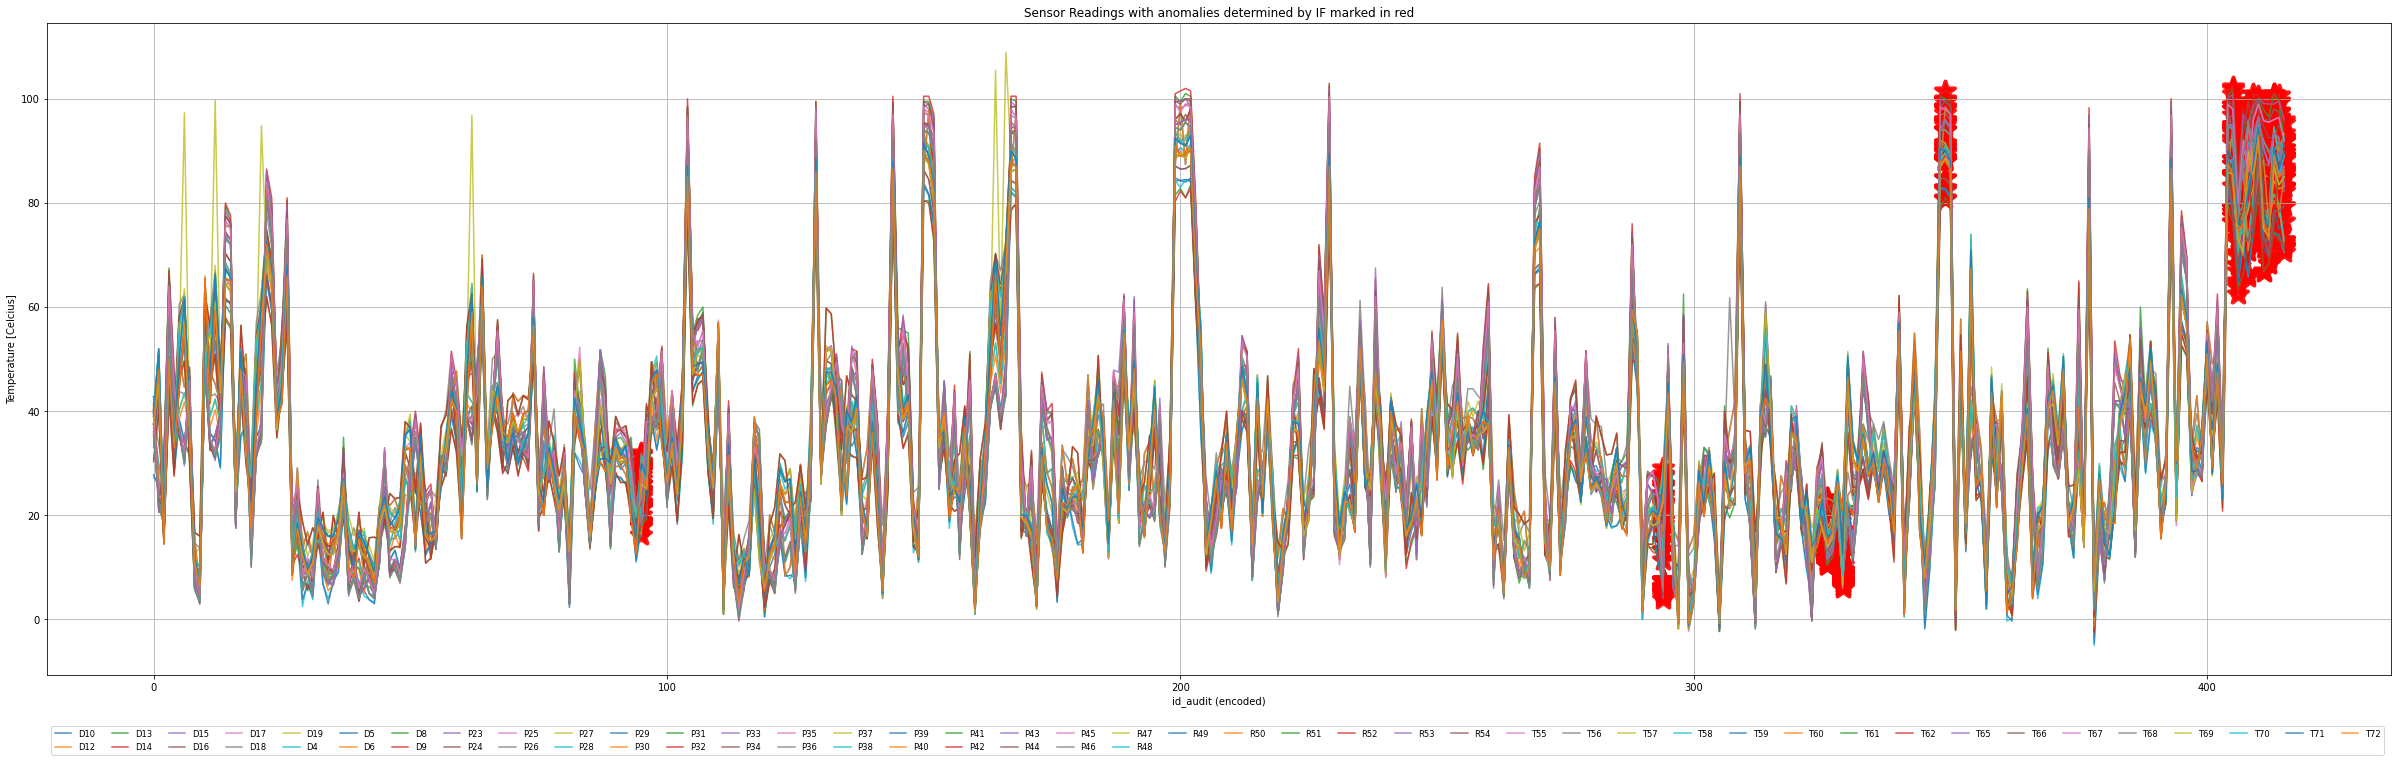

In [48]:
# Define sensors and sensors with anomalies
sensors = list(filter(lambda v: re.match('^\w\d+$', v), anomaly_plot_df.columns))
sensors_with_anomalies = [sensor for sensor in sensors if df_anomalous[sensor].notna().any()]
print(sensors_with_anomalies)

# Plot

plt.figure(figsize=(42, 12))

for sensor in sensors:
    # Plot the continuous line for for all sensor readings
    plt.plot(
        anomaly_plot_df['id_audit_le'],
        anomaly_plot_df[sensor],
        label=f'{sensor}',
        alpha=0.8
    )
    
    # Mark anomalies
    plt.scatter(
        anomaly_plot_df[anomaly_plot_df['anomaly'] == 1]['id_audit_le'],
        anomaly_plot_df[anomaly_plot_df['anomaly'] == 1][sensor],
        color='red',
        marker='*',
        s=400,
        edgecolors='red',
        linewidth=4,
        alpha=0.9
    )

# Customize the plot
plt.xlabel('id_audit (encoded)')
plt.ylabel('Temperature [Celcius]')
plt.title('Sensor Readings with anomalies determined by IF marked in red')
plt.legend(loc='center left', ncol=42, fontsize='small', bbox_to_anchor=(0, -0.1))
plt.grid(True)
plt.show()